# Tobig's 14기 6주차 Neural Network Assignment2
### Made by 이지용

In [58]:
import numpy as np
from matplotlib import pyplot as plt

## 데이터 불러오기

학습에 쓰일 데이터는 keras의 cifar-10 데이터입니다.  
32x32 이미지에 색상을 rgb 3가지로 분류한 데이터로 총 3072 차원입니다.  
이 이미지를 10가지 카테고리로 분류했습니다.  
https://www.cs.toronto.edu/~kriz/cifar.html

In [59]:
x_train = np.load("./x_train_data.npy")
y_train = np.load("./y_train_data.npy")
x_test = np.load("./x_test_data.npy")
y_test = np.load("./y_test_data.npy")

In [60]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5000, 3072), (5000,), (1000, 3072), (1000,))

## 활성화 함수 클래스

신경망에 사용될 함수들을 정의합니다.

### Activation Functions

In [61]:
class sigmoid :
    # sigmoid 함수입니다.
    def forward(z) :
        c = np.max(z)/2
        return np.exp(c)/(np.exp(c)+np.exp(-z+c))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(a) :
        return a*(1-a)
        

* sigmoid 함수는 s자 형태를 띄는 함수이다. 
* 입력값이 커질수록 1로 수렴, 입력값이 작을수록 0에 수렴한다. 
* 장점 : 출력값의 범위가 (0, 1)로 제한되고, 미분식이 단순한 형태이다.
* 단점 : Vanishing Gradient 문제 발생(식에 따르면 입력이 아무리 커도 미분값의 범위는 (0, 1/4)이다. 그렇기 때문에 미분값이 0에 수렴할 것이고, 학습의 효율이 매우 떨어질수있다.), exp연산은 비용이 크다고 한다.

In [62]:
z = np.array([-1,2,3])

In [63]:
sigmoid.forward(z)

array([0.26894142, 0.88079708, 0.95257413])

In [64]:
sigmoid.backward(z)

array([-2, -2, -6])

In [65]:
class relu :
    # relu 함수를 작성하세요
    def forward(z) :
        return np.maximum(0, z)
    
    # relu 함수의 미분을 작성하세요
    def backward(a) :
        return np.where(a > 0, 1, 0)

* sigmoid함수의 Vanishing Gradient 문제를 해결하기 위해 사용하는것이 ReLU(Rectified Linear Unit)이다.
* 현재 딥러닝에서 가장 많이 사용하는 활성화 함수 중 하나라고 한다.
* 장점 : 연산속도가 빠르다(비교연산 1회를 통해 함숫값을 구할수 있다고한다), 모든 정보에 반응하는 것이 아닌 효율적으로 정보를 수용한다
* 단점 : Dying ReLU(입력값이 0또는 음수일때, 학습을 하지못한다.) -- 이문제를 해결하기위해 Leaky ReLU, PReLU(Parametric ReLU), ELU(Exponential Linear Unit)등의 유사함수가 만들어진다고한다. 

In [66]:
relu.forward(z)

array([0, 2, 3])

In [67]:
relu.backward(z)

array([0, 1, 1])

### Output Activation Function

softmax는 overflow 문제와 차원 문제 때문에 작성해두었습니다.
이 부분은 softmax overflow문제에 대해 검색해보세요. 
#### Softmax는 수식에 e^x 들어가기 때문에 Overflow 범위를 넘어설 수 있다. 이를 해결하기 위해  Softmax의 성질(원소에 어떠한 수를 더하여 exp를 취하더라도 결과 값이 같다)을 이용한다.

In [68]:
class softmax :
    def forward(z) :
        y = []
        for zi in z :
            #print("z", z[0])
            c = np.max(zi) #최댓값 저장 
            exp_zi = np.exp(zi-c) # 각각의 원소에서 최댓값을 빼준뒤 exp를 취한다.(overflow 방지)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)
            #print("y", y[0])
        #print(y[0])
        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

In [69]:
z = np.array([[np.log(1), np.log(3), np.log(4)]])
p = np.array([[0.125, 0.375, 0.5]])
y = np.array([2])

In [70]:
softmax.forward(z)

array([[0.125, 0.375, 0.5  ]])

In [71]:
softmax.backward(p, y)

array([[ 0.125,  0.375, -0.5  ]])

### Loss Functions

−∑𝑦𝑘 log(𝑝𝑘)= − log 𝑝𝑖, (1 ≤ 𝑖 ≤ K)에 따라서 빈칸을 채워준다.

In [72]:
def cross_entropy(p, y) :
    # cross entropy 함수를 작성하세요
    loss = []
    for pi, yi in zip(p, y) :
        for k in range(p.shape[1]) :
            if k == yi :
                loss.append(-np.log(pi[k]+1e-8))# 1e-8은 무한대로 발산하는 경우를 방지하기 위해 존재합니다
    return loss

In [73]:
cross_entropy(p, y)

[0.6931471605599454]

## 레이어 클래스

각 레이어의 크기와 형태를 입력값과 출력값에 따라 정의합니다.

In [74]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(self.output_size) 
        self.weight = np.random.randn(self.input_size, self.output_size)*std # std는 가중치 초기화에서 표준편차를 줄이기 위해 존재합니다.
                                    

## 뉴럴넷 클래스

각 메소드와 변수들의 역할을 주석에 달아주세요 

In [75]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200) :
        self.lr = lr #학습률
        self.epoch = epoch #한번의 epoch는 전체 데이터 셋에 대해서 forward + backward가 완료된 상태를 말한다. 
        #적절한 epoch값을 설정하여야 underfitting과 overfitting을 방지할수있다. 
        self.batch_size = batch_size # 한번 batch마다 주는 데이터 샘플의 사이즈
        self.loss_function = cross_entropy # mse로 대체 가능하지만 이번 과제는 분류이므로 cross_entropy로 넣었어요.
        self.layers = [] #쌓을 층
        self.activations = [softmax] #활성화함수
        self.nodes = [] #각 층의 노드 
    
    # Layer를 추가할 때 호출합니다.
    def addLayer(self, Layer) : 
        self.layers.append(Layer)
        if not self.nodes :
            self.nodes.append(np.zeros(Layer.input_size)) #self.nodes가 비어있으면 input_size만큼 추가해주고
        self.nodes.append(np.zeros(Layer.output_size))    #비어있지 않으면 output_size를 차례대로 넣어준다. 
    
    # Activation Function을 추가할 때 호출합니다.
    def addActivation(self, Activation):
        tmp = self.activations.pop()
        self.activations.append(Activation)
        self.activations.append(tmp)
        
    # 순전파 함수
    def _forward(self, X) :
        self.nodes[0] = X.copy()
        output = X.copy()
        for i in range(len(self.layers)):
            Layer = self.layers[i]
            Activation = self.activations[i]
            #𝑊𝒙 + 𝒃를 만족하는 식을 구현한다. 
            output = np.dot(self.nodes[i], Layer.weight) #𝑊𝒙 : 노드의 값과 가중치값을 행렬곱한다
            output = output+ Layer.bias # +b : output에 bias값을 더한다.
            output = Activation.forward(output) #𝑊𝒙 + 𝒃를 활성화 함수에 결과를 도출한다
            #Layer.output = output
            self.nodes[i+1] = output 
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))):
            a = self.nodes[i+1]
            Layer = self.layers[i]
            Activation = self.activations[i]
            if i+1 == len(self.layers):
                error = Activation.backward(output, y)
            else :
                error *= Activation.backward(a)
            #print(error.shape, X.shape, output.shape,y.shape)
            #weight에서 (error*x)*lr을 빼주면서 업데이트 시키기위한 식을 구현한다.
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0]
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error, Layer.weight.T) #각 층에서 업데이트 된 weight와 error 값을 곱하여 최종값으로 출력
    
    # Accrucy를 반환합니다.
    def _accuracy(self, output, y) :
        pre_p = np.argmax(output, axis=1)
        return np.sum(pre_p==y)/y.shape[0]
    
    # 데이터셋에 모델을 fit할때 호출합니다.
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch) :
            for j in range(N//self.batch_size) :
                batch_mask = np.random.choice(N, self.batch_size) #이미 있는 데이터 집합에서 일부를 무작위로 선택
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                output = self._forward(X_batch) #순전파 실행
                #loss = self.loss_function(output, y_batch)
                self._backward(X_batch, output, y_batch) #역전파 실행
            
            #accuracy와 loss를 기록해둡시다.
            output = self._forward(val_X)
            history["val_acc"].append(self._accuracy(output, val_y))
            history["val_loss"].append(sum(self.loss_function(output, val_y)))
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요.
            if i % 50 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

In [26]:
# 에폭을 85, batch_size를 400으로 주고, 층의 수를 다르게 주어보았다!
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

nn.addLayer(Layer(3072,1500))
nn.addActivation(sigmoid)
nn.addLayer(Layer(1500,10))

In [27]:
# 선언한 뉴럴넷의 구조입니다.
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 1500) (1500,)
(1500, 10) (10,)


In [28]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.103
0 test loss     : 2529.354876518854
50 test accuracy : 0.297
50 test loss     : 1962.160506711721


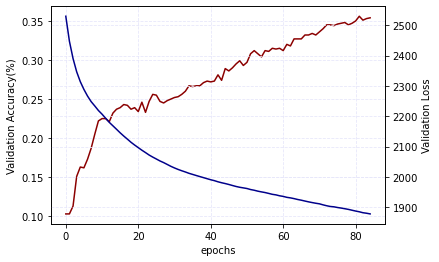

Best Validation Accuracy :  0.356


In [29]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

* epoch은 늘리고  batch_size는 줄여준 다음, 층의 개수를 다르게 줘보니 성능이 좋아졌다!

In [30]:
# 파라미터는 위와 동일하게 주고, 층의 수를 다르게 주어보았다!
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

nn.addLayer(Layer(3072,2000))
nn.addActivation(sigmoid)
nn.addLayer(Layer(2000,10))

In [31]:
# 선언한 뉴럴넷의 구조입니다.
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 2000) (2000,)
(2000, 10) (10,)


In [32]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.1
0 test loss     : 2561.3592430212166
50 test accuracy : 0.308
50 test loss     : 1922.0764570139816


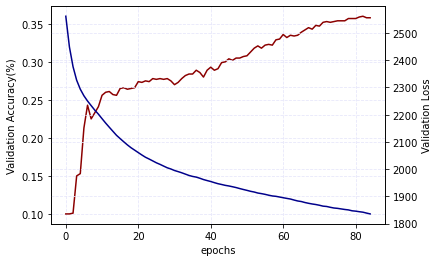

Best Validation Accuracy :  0.36


In [33]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

* 아주 살짝 더좋아졌다 ㅎㅎ

In [41]:
# 파라미터는 위와 동일하게 주고, 층을 하나 더 쌓아보았다.
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

nn.addLayer(Layer(3072,2000))
nn.addActivation(sigmoid)
nn.addLayer(Layer(2000,500))
nn.addActivation(sigmoid)
nn.addLayer(Layer(500,10))

In [42]:
# 선언한 뉴럴넷의 구조입니다.
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 2000) (2000,)
(2000, 500) (500,)
(500, 10) (10,)


In [43]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.112
0 test loss     : 2578.0750371284107
50 test accuracy : 0.106
50 test loss     : 2301.7396260541377


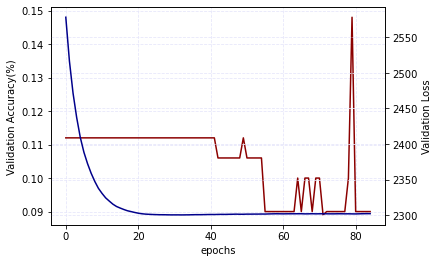

Best Validation Accuracy :  0.148


In [44]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

* loss는 계속 줄어들다가 일정한 모양을 보였지만, 정확도는 요동을 친다,, 정확도가 0.148로 굉장히 작게나왔다. 활성화함수를 두개다 sigmoid로 해서 그런가 싶어서 relu로 바꿔서 실행해보았다!

In [80]:
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

nn.addLayer(Layer(3072,2000))
nn.addActivation(sigmoid)
nn.addLayer(Layer(2000,500))
nn.addActivation(relu)
nn.addLayer(Layer(500,10))

In [77]:
# 선언한 뉴럴넷의 구조입니다.
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 2000) (2000,)
(2000, 500) (500,)
(500, 10) (10,)


In [78]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.103
0 test loss     : 2742.316109509108
50 test accuracy : 0.11
50 test loss     : 2299.310518753867


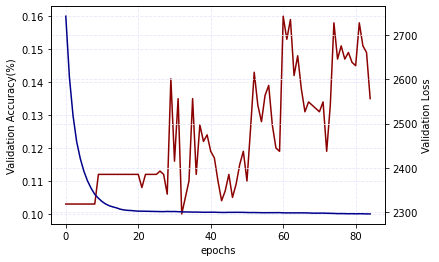

Best Validation Accuracy :  0.16


In [79]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

* relu로 바꿔도 결과는 비슷하다

In [81]:
#이번에는 2Layer로 하고 함수만 relu로 바꿔보았다
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

nn.addLayer(Layer(3072,2000))
nn.addActivation(relu)
nn.addLayer(Layer(2000,10))

In [82]:
# 선언한 뉴럴넷의 구조입니다.
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 2000) (2000,)
(2000, 10) (10,)


In [83]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.139
0 test loss     : 2355.0422832683535
50 test accuracy : 0.407
50 test loss     : 1629.1023261515716


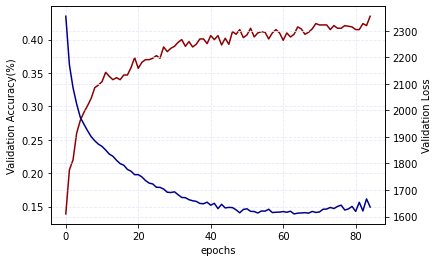

Best Validation Accuracy :  0.435


In [84]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

* 2Layer에서 활성화함수를 relu로 바꾸었더니 정확도가 가장 높게 나왔다!!

정리해보자면 가장 높은 정확도를 보인 모델은 정확도가 0.435인 아래모델이다!

nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

nn.addLayer(Layer(3072,2000))

nn.addActivation(relu)

nn.addLayer(Layer(2000,10))